# UofT FASE ML Bootcamp
#### Friday June 14, 2024
####  Word Embeddings - Properties, Meaning and Training - Lab 1, Day 5
#### Teaching team: Eldan Cohen, Alex Olson, Nakul Upadhya, Hriday Chheda
##### Based on CARTE-DSI ML Bootcamp 2023 notebook by Prof. Jonathan Rose

This lab engages you in the properties, meaning, viewing and training of word embeddings (also called word vectors). The specific learning objectives in this assignment are:

1.   To learn word embedding properties, and use them in simple ways.
2.   (optional) To translate vectors into understandable categories of meaning
3.   To understand how embeddings are created, using the Skip Gram method.

---





# 1. Experimenting and Understanding Word Embedding/Vectors
# Using the GloVe Embeddings


Word embeddings (also known as word vectors) are a way to encode the meaning of words into a set of numbers.

These embeddings are created by training a neural network model using many examples of the use of language.  These examples could be the whole of Wikipedia or a large collection of news articles.

To start, we will explore a set of word embeddings that someone else took the time and computational power to create. One of the most commonly-used pre-trained word embeddings are the **GloVe embeddings**.

## GloVe Embeddings

You can read about the GloVe embeddings here: https://nlp.stanford.edu/projects/glove/, and read the original paper describing how they work here: https://nlp.stanford.edu/pubs/glove.pdf.

There are several variations of GloVe embeddings. They differ in the text used to train the embedding, and the *size* of the embeddings.

Throughout this lab we'll use a package called `torchtext`, that is part of PyTorch.

We'll begin by loading a set of GloVe embeddings. The first time you run the code below, it will cause the download of a large file (862MB) containing the embeddings.

In [2]:
# Import the required libraries
import torch
import torchtext
import pandas as pd
torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import GloVe

In [3]:
# The first time you run this will download a ~862MB file
glove = GloVe(name="6B", # trained on Wikipedia 2014 corpus
              dim=50)  # embedding size = 50

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:23<00:00, 16729.41it/s]


We can use the loaded glove embeddings to look up the embeddings of individual words.
For example, let's look at what the embedding of the word "apple" looks like:

In [4]:
glove['apple']

tensor([ 0.5204, -0.8314,  0.4996,  1.2893,  0.1151,  0.0575, -1.3753, -0.9731,
         0.1835,  0.4767, -0.1511,  0.3553,  0.2591, -0.7786,  0.5218,  0.4769,
        -1.4251,  0.8580,  0.5982, -1.0903,  0.3357, -0.6089,  0.4174,  0.2157,
        -0.0742, -0.5822, -0.4502,  0.1725,  0.1645, -0.3841,  2.3283, -0.6668,
        -0.5818,  0.7439,  0.0950, -0.4787, -0.8459,  0.3870,  0.2369, -1.5523,
         0.6480, -0.1652, -1.4719, -0.1622,  0.7986,  0.9739,  0.4003, -0.2191,
        -0.3094,  0.2658])

As we can see from the output above, the embedding of a given word is a torch tensor with dimension `(50,)`. We don't know what the meaning of each number is, but we do know that there are properties of the embeddings that can be observed. For example, `distances between embeddings` are meaningful.

## Measuring Distance

Let's consider one specific metric of distance between two embedding vectors called the **Euclidean distance**. The Euclidean distance of two vectors $x = [x_1, x_2, ... x_n]$ and
$y = [y_1, y_2, ... y_n]$ is just the 2-norm of their difference $x - y$. We can compute
the Euclidean distance between $x$ and $y$: $\sqrt{\sum_i (x_i - y_i)^2}$

The PyTorch function `torch.norm` computes the 2-norm of a vector for us, so we
can compute the Euclidean distance between two vectors like this:

In [5]:
x = glove['cat']
y = glove['dog']
torch.norm(y - x)

tensor(1.8846)

In [6]:
a = glove['apple']
b = glove['orange']
torch.norm(b - a)

tensor(4.9094)

In [7]:
torch.norm(glove['good'] - glove['bad'])

tensor(3.3189)

In [8]:
torch.norm(glove['good'] - glove['water'])

tensor(5.3390)

In [9]:
torch.norm(glove['good'] - glove['well'])

tensor(2.7703)

In [10]:
torch.norm(glove['good'] - glove['perfect'])

tensor(2.8834)

## Cosine Similarity

An alternative and more commonly-used measure of distance is the **Cosine Similarity**. The cosine similarity measures the *angle* between two vectors, and has the property that it only considers the *direction* of the vectors, not their the magnitudes. It is computed as follows for two vectors A and B:


![picture](https://drive.google.com/uc?id=1hSaQRBjH828lx1xozJCA4F0ZhiX2S0Xt)

In [11]:
#consider two vectors x and y
#unsqueeze is used because cosine similarity wants at least 2-D inputs
x = torch.tensor([1., 1., 1.]).unsqueeze(0)
y = torch.tensor([2., 2., 2.]).unsqueeze(0)

# Calculate the cosine similarity between x and y
# Expect the cosine similarity to be 1.0 since x and y are in the same direction
torch.cosine_similarity(x, y)

tensor([1.0000])

The cosine similarity is actually a *similarity* measure rather than a *distance* measure, and gives a result between -1 and 1. Thus, the larger the similarity, (closer to 1) the "closer in meaning" the word embeddings are to each other.

In [12]:
z = torch.tensor([-1., -1., -1.]).unsqueeze(0)

# Calculate the cosine similarity between x and z
# Expect the cosine similarity to be -1.0 since x and z point in the opposite "direction"
torch.cosine_similarity(x, z)

tensor([-1.0000])

In [13]:
x = glove['cat']
y = glove['dog']
torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))

tensor([0.9218])

In [14]:
a = glove['apple']
b = glove['banana']
torch.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))

tensor([0.5608])

In [15]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['bad'].unsqueeze(0))

tensor([0.7965])

In [16]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['water'].unsqueeze(0))

tensor([0.5540])

In [17]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['well'].unsqueeze(0))

tensor([0.8511])

In [18]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['perfect'].unsqueeze(0))

tensor([0.8376])

In [19]:
torch.cosine_similarity(glove['watermelon'].unsqueeze(0),
                        glove['aeroplane'].unsqueeze(0))

tensor([-0.1102])

Note: torch.cosine_similarity requires two dimensions to work, which is created with the unsqueeze option, illustrated in more detail below

In [20]:
x = glove['good']
print(x.shape) # [50]
y = x.unsqueeze(0) # [1, 50]
print(y.shape)

torch.Size([50])
torch.Size([1, 50])


## Word Similarity

Now that we have notions of distance and similarity in our embedding space, we can talk about words that are "close" to each other in the embedding space. For now, let's use Euclidean distances to look at how close various words are to the word "cat".

In [21]:
word = 'cat'
other = ['pet', 'dog', 'bike', 'kitten', 'puppy', 'kite', 'computer', 'neuron']
for w in other:
    dist = torch.norm(glove[word] - glove[w]) # euclidean distance
    print(w, "\t%5.2f" % float(dist))

pet 	 3.04
dog 	 1.88
bike 	 5.05
kitten 	 3.51
puppy 	 3.06
kite 	 4.21
computer 	 6.03
neuron 	 6.23


Let's do the same thing with cosine similarity:

In [22]:
word = 'cat'
other = ['pet', 'dog', 'bike', 'kitten', 'puppy', 'kite', 'computer', 'neuron']
for w in other:
    dist = torch.cosine_similarity(glove[word].unsqueeze(0),glove[w].unsqueeze(0)) # cosine distance
    print(w, "\t%5.2f" % float(dist))

pet 	 0.78
dog 	 0.92
bike 	 0.44
kitten 	 0.64
puppy 	 0.76
kite 	 0.49
computer 	 0.35
neuron 	 0.21


We can look through the entire **vocabulary** for words that are closest to a point in the embedding space -- for example, we can look for words that are closest to another word such as "cat".

In [23]:
def print_closest_words(vec, n=5):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    closest_words = []
    for idx, difference in lst[1:n+1]:                         # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)
        closest_words.append(glove.itos[idx])
    return closest_words

closest_words_to_cat = print_closest_words(glove["cat"], n=10)

dog 	 1.88
rabbit 	 2.46
monkey 	 2.81
cats 	 2.90
rat 	 2.95
beast 	 2.99
monster 	 3.00
pet 	 3.04
snake 	 3.06
puppy 	 3.06


In [24]:
closest_words_to_dog = print_closest_words(glove['dog'])

cat 	 1.88
dogs 	 2.65
puppy 	 3.15
rabbit 	 3.18
pet 	 3.23


In [25]:
closest_words_to_nurse = print_closest_words(glove['nurse'])

doctor 	 3.13
dentist 	 3.13
nurses 	 3.27
pediatrician 	 3.32
counselor 	 3.40


In [26]:
closest_words_to_computer = print_closest_words(glove['computer'])

computers 	 2.44
software 	 2.93
technology 	 3.19
electronic 	 3.51
computing 	 3.60


In [27]:
#You can also try printing closest words to any other words of your choice here:



We could also look at which words are closest to the midpoints of two words:

In [28]:
closest_to_mid_1 = print_closest_words((glove['happy'] + glove['sad']) / 2)

happy 	 1.92
feels 	 2.36
sorry 	 2.50
hardly 	 2.53
imagine 	 2.57


In [29]:
closest_to_mid_2 = print_closest_words((glove['lake'] + glove['building']) / 2)

surrounding 	 3.07
nearby 	 3.11
bridge 	 3.16
along 	 3.16
shore 	 3.16


In [30]:
closest_to_mid_3 = print_closest_words((glove['bravo'] + glove['michael']) / 2)

farrell 	 2.80
anderson 	 2.85
jacobs 	 2.85
boyle 	 2.86
slater 	 2.87


##1.1
1.1.1 Write a new function, similar to print_closest_words called print_closest_cosine_words that prints out the N-most (where N is an input parameter) similar words using cosine similarity rather than euclidean distance.

The documentation for the [sorted](https://python-reference.readthedocs.io/en/latest/docs/functions/sorted.html) method in python might help



In [31]:
def print_closest_cosine_words(vec, n=5):
  # TODO
  sims = torch.cosine_similarity(glove.vectors, vec, dim=1)  # compute similarities to all words
  lst =  sorted(enumerate(sims.numpy()), key=lambda x: x[1], reverse=True) # sort by similarity (descending order, remember higher similarity score, closer the word)
  closest_words = []
  # take the top n
  for idx, similarity in lst[1:n+1]:
    print(glove.itos[idx], "\t%5.2f" % similarity)
    closest_words.append(glove.itos[idx])
  return closest_words

1.1.2 Create a table that compares the 10-most cosine-similar words to the word 'dog', in order, alongside to the 10 closest

In [34]:
closest_euclidean_words = print_closest_words(glove['dog'], n=10)
print("\n")
closest_cosine_words = print_closest_cosine_words(glove['dog'], n=10)
print("\n")
table = pd.DataFrame()
table["Euclidean"] = closest_euclidean_words
table["Cosine"] = closest_cosine_words
print(table)

cat 	 1.88
dogs 	 2.65
puppy 	 3.15
rabbit 	 3.18
pet 	 3.23
horse 	 3.25
pig 	 3.39
pack 	 3.43
cats 	 3.44
bite 	 3.46


cat 	 0.92
dogs 	 0.85
horse 	 0.79
puppy 	 0.78
pet 	 0.77
rabbit 	 0.77
pig 	 0.75
snake 	 0.74
baby 	 0.74
bite 	 0.74


  Euclidean  Cosine
0       cat     cat
1      dogs    dogs
2     puppy   horse
3    rabbit   puppy
4       pet     pet
5     horse  rabbit
6       pig     pig
7      pack   snake
8      cats    baby
9      bite    bite


In [36]:
# Compute the same table for word "computer"
closest_euclidean_words = print_closest_words(glove['computer'], n=10)
print("\n")
closest_cosine_words = print_closest_cosine_words(glove['computer'], n=10)
print("\n")
table = pd.DataFrame()
table["Euclidean"] = closest_euclidean_words
table["Cosine"] = closest_cosine_words
print(table)

computers 	 2.44
software 	 2.93
technology 	 3.19
electronic 	 3.51
computing 	 3.60
devices 	 3.67
hardware 	 3.68
internet 	 3.69
applications 	 3.69
digital 	 3.70


computers 	 0.92
software 	 0.88
technology 	 0.85
electronic 	 0.81
internet 	 0.81
computing 	 0.80
devices 	 0.80
digital 	 0.80
applications 	 0.79
pc 	 0.79


      Euclidean        Cosine
0     computers     computers
1      software      software
2    technology    technology
3    electronic    electronic
4     computing      internet
5       devices     computing
6      hardware       devices
7      internet       digital
8  applications  applications
9       digital            pc


1.1.3 Looking at the two lists, does one of the metrics (cosine similarity or euclidean distance) seem to be better than the other?

When we look at the closest words from both the metrics they are more or less the same. At this point, there is no clear better metric. Both seem to be selecting similar closest words


## 1.2 Analogies

One surprising aspect of word embeddings is that the *directions* in the embedding space can be meaningful. For example, some analogy-like relationships like this tend to hold:

$$ king - man + woman \approx queen $$

Analogies show us how relationships between pairs of words that is captured in the learned vectors

In [38]:
_ = print_closest_words(glove['king'] - glove['man'] + glove['woman'])

queen 	 2.84
prince 	 3.66
elizabeth 	 3.72
daughter 	 3.83
widow 	 3.85


The top result is a reasonable answer like "queen",  and the name of the queen of england.

We can flip the analogy around and it works:

In [ ]:
_ = print_closest_words(glove['queen'] - glove['woman'] + glove['man'])

king 	 2.84
prince 	 3.25
crown 	 3.45
knight 	 3.56
coronation 	 3.62


In [ ]:
_ = print_closest_words(glove['king'] - glove['prince'] + glove['princess'])

queen 	 3.18
king 	 3.91
bride 	 4.29
lady 	 4.30
sister 	 4.42


In [ ]:
_ = print_closest_words(glove['uncle'] - glove['man'] + glove['woman'])

grandmother 	 2.32
aunt 	 2.35
granddaughter 	 2.36
daughter 	 2.40
uncle 	 2.60


In [ ]:
_ = print_closest_words(glove['grandmother'] - glove['mother'] + glove['father'])

uncle 	 2.08
father 	 2.09
grandson 	 2.30
nephew 	 2.35
elder 	 2.43


In [ ]:
_ = print_closest_words(glove['old'] - glove['young'] + glove['father'])

father 	 4.03
son 	 4.41
grandfather 	 4.52
grandson 	 4.72
daughter 	 4.79


We can also move an embedding towards the direction of "goodness" or "badness":

In [ ]:
_ = print_closest_words(glove['good'] - glove['bad'] + glove['programmer'])

versatile 	 4.38
creative 	 4.57
entrepreneur 	 4.63
enables 	 4.72
intelligent 	 4.73


In [ ]:
_ = print_closest_words(glove['bad'] - glove['good'] + glove['programmer'])

hacker 	 3.84
glitch 	 4.00
originator 	 4.04
hack 	 4.05
serial 	 4.23


1.2.1 Consider now the word pair relationships given in Figure 1 below, which comes from Table 1 of the Mikolov [[link](https://arxiv.org/abs/1301.3781)] paper. Choose one of these relationships, but not one of the ones already shown above, and report which one you chose. Write and run code that will generate the second word given the first word. Generate 10 more examples of the same relationship from 10 other words, and comment on the quality of the results.

![picture](https://drive.google.com/uc?id=1O7Zizu63jj5aoZkGkK0sz93CZSEsBDuW)



In [71]:
# TODO
# Choose one of the relationships from the table above and generate 10 examples
_ = print_closest_words(glove['athens'] - glove['city'] + glove['country'])
print("\n")
_ = print_closest_words(glove['chicago'] - glove['city'] + glove['state'])
print("\n")

greece 	 7.59
country 	 8.01
cyprus 	 8.82
greek 	 9.00
warned 	 9.11


chicago 	 7.81
illinois 	 8.00
arizona 	 8.04
michigan 	 8.13
minnesota 	 8.23




## 1.3 Change Embedding Dimension
Now we change the embedding dimension (also known as the vector size) from 50 to 300 and re-run all the examples from above including the new cosini similarity function. Answer the following questions:
1.   How does the euclidean distance change between the various words when switching from d=50 to d=300?
2.   How does the cosine similarity change?
3.   Does the ordering of nearness change?
4.   Is it clear that the larger size vectors give better results - why or why not?



In [52]:
# The first time you run this will download a ~862MB file
glove = GloVe(name="6B", # trained on Wikipedia 2014 corpus
              dim=300)  # embedding size = 300

100%|█████████▉| 399999/400000 [01:18<00:00, 5111.58it/s]


Let's check the euclidean distances for embedding dimension of 300

In [53]:
x = glove['cat']
y = glove['dog']
torch.norm(y - x)

tensor(5.1959)

In [54]:
a = glove['apple']
b = glove['orange']
torch.norm(b - a)

tensor(8.1147)

In [55]:
torch.norm(glove['good'] - glove['bad'])

tensor(4.8563)

In [56]:
torch.norm(glove['good'] - glove['water'])

tensor(7.5312)

In [57]:
torch.norm(glove['good'] - glove['well'])

tensor(4.0593)

In [58]:
torch.norm(glove['good'] - glove['perfect'])

tensor(5.2142)

1.3.1 Compare to the euclidean distances from above (embedding dimension of 50) and answer question 1. How does the euclidean distance change between the various words when switching from d=50 to d=300?

Answer: The distances increase. For example the distance between good and bad was 3.31 but now it is 4.85.

Next, lets look at cosine similarity with embedding dimension 300

In [59]:
x = glove['cat']
y = glove['dog']
torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))

tensor([0.6817])

In [60]:
a = glove['apple']
b = glove['banana']
torch.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))

tensor([0.3924])

In [61]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['bad'].unsqueeze(0))

tensor([0.6445])

In [62]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['water'].unsqueeze(0))

tensor([0.3373])

In [63]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['well'].unsqueeze(0))

tensor([0.7046])

In [64]:
torch.cosine_similarity(glove['good'].unsqueeze(0),
                        glove['perfect'].unsqueeze(0))

tensor([0.5893])

In [65]:
torch.cosine_similarity(glove['watermelon'].unsqueeze(0),
                        glove['aeroplane'].unsqueeze(0))

tensor([0.0955])

1.3.2 Compare to the cosine similarities from above (embedding dimension of 50) and answer question 2. How does the cosine similarity change when switching from d=50 to d=300?

Answer: The cosine similarities values are lower when compared to the embedding dimension of 50

Next, we will look at the nearness of words

In [67]:
closest_euclidean_words = print_closest_words(glove['dog'])
closest_cosine_words = print_closest_cosine_words(glove['dog'])
table = pd.DataFrame()
table["Euclidean"] = closest_euclidean_words
table["Cosine"] = closest_cosine_words
print(table)

dogs 	 4.36
cat 	 5.20
pet 	 5.70
puppy 	 5.86
hound 	 6.22
dogs 	 0.79
cat 	 0.68
pet 	 0.63
puppy 	 0.59
hound 	 0.55
  Euclidean Cosine
0      dogs   dogs
1       cat    cat
2       pet    pet
3     puppy  puppy
4     hound  hound


1.3.3 Compare to the near words from above (embedding dimension of 50) and answer question 3. Does the ordering of nearness words change?

Answer: Yes, the ordering changes dogs is now higher than cat, pet is also higher than before.

1.3.4 Is it clear that the larger size vectors give better results - why or why not?

Answer: THe larger size is giving us better results (not by much in this example), but there is an improvement. "dogs" is now the closest to dog rather than cat which was before. "hound" also makes it to the top 5 list which is intuitively closer to dog than rabbit or horse which were included first. \\
In general, larger embeddings (e.g., 300 dimensions vs. 50 dimensions) have the potential to capture more nuanced semantic relationships between words. This can lead to better performance on tasks requiring a deep understanding of word meanings and contexts. It is important to note that while increasing the embedding size can improve performance, the gains may diminish beyond a certain point. For instance, the improvement from 50 to 300 dimensions might be substantial, but the improvement from 200 to 300 dimensions might be marginal.

# 2. (Optional): Computing Meaning from Word Embeddings

Now that we’ve seen some of the power of word embeddings, we can also feel the frustration that the individual elements/numbers in each word vector do not have a meaning that can be interpreted or understood by humans. It would have preferable that each position in the vector correspond to a specific axis of meaning that we can understand based on our ability to comprehend language.

For example the "amount" the word related to *colour* or *temperature* or *politics*. This is not the case, because the numbers are the result of an optmization process that does not drive each vector element toward human-understandable meaning.

We can, however, make use of the methods shown in Section 1 above to measure the amount of meaning in specific categories of our choosing, such as colour. Suppose that we want to know how much a particular word/embedding relates to colour. One way to measure that could be to determine the cosine similarity between the word embedding for colour and the word of interest. We might expect that a word like ‘sky’ or ‘grass’ might have elements of colour in it, and that ‘purple’ would have more. However, it may also be true that there are multiple meanings to a single word, such as ‘colour’, and so it might be better to define a category of meaning by using several words that, all together, define it with more precision.

For example, a way to define a category such as colour would be to use that word itself, and to- gether with several examples, such ‘red’, ‘green’, ‘blue’, ‘yellow.’ Then, to measure the “amount” of colour in a specific word (like ‘sky’) you could compute the average cosine similarity between sky and each of the words in the category. Alternatively, you could average the vectors of all the words in the category, and compute the cosine similarity between the embedding of sky and that average embedding. In this section, use the d=50 GlOVe embeddings that you used in Section 1.



In [93]:
# Load GloVe embeddings using torchtext
glove = GloVe(name='6B', dim=50)
embedding_size = 50  # Size of GloVe embeddings

##2.1
Write a PyTorch-based function called compare words to category that takes as input:
* The meaning category given by a set of words (as discussed above) that describe the category, and
* A given word to ‘measure’ against that category.


The function should compute the cosine similarity of the given word in the category in two ways: \\
(a) By averaging the cosine similarity of the given word with every word in the category, and \\
(b) By computing the cosine similarity of the word with the average embedding of all of the words in the category.

In [94]:
# Function to convert a word to its embedding
def word_to_embedding(word, glove):
    if word in glove.stoi:
        return glove[word]
    else:
        return torch.zeros(embedding_size)

def compare_words_to_category(word, category_words, glove):
    word_embedding = word_to_embedding(word, glove).unsqueeze(0)
    category_embeddings = torch.stack([word_to_embedding(w, glove) for w in category_words])

    # Method (a): Average cosine similarity of the given word with every word in the category
    cosine_similarities = torch.cosine_similarity(word_embedding, category_embeddings, dim=1) # TODO
    avg_cosine_similarity = cosine_similarities.mean().item()

    # Method (b): Cosine similarity of the word with the average embedding of the category words
    avg_category_embedding = category_embeddings.mean(dim=0, keepdim=True) # TODO
    avg_category_cosine_similarity = torch.cosine_similarity(word_embedding, avg_category_embedding).item()

    return avg_cosine_similarity, avg_category_cosine_similarity

##2.2
Let’s define the colour meaning category using these words: “colour”, “red”, “green”, “blue”, “yellow.” Compute the similarity (using both methods (a) and (b) above) for each of these words: “greenhouse”, “sky”, “grass”, “purple”, “scissors”, “microphone”, “president” and present them in a table.

In [96]:
category_words = ["colour", "red", "green", "blue", "yellow"]
words_to_measure = ["greenhouse", "sky", "grass", "purple", "scissors",
                    "microphone", "president"]

results = []
for word in words_to_measure:
    avg_cosine_similarity, avg_category_cosine_similarity = compare_words_to_category(word, category_words, glove) # TODO
    results.append((word, avg_cosine_similarity, avg_category_cosine_similarity))

# Create a DataFrame to present the results in a table
df_results = pd.DataFrame(results, columns=["Word", "Avg Cosine Similarity", "Cosine Similarity with Avg Embedding"])
print(df_results)

         Word  Avg Cosine Similarity  Cosine Similarity with Avg Embedding
0  greenhouse               0.183072                              0.201687
1         sky               0.601871                              0.670239
2       grass               0.506045                              0.557923
3      purple               0.799313                              0.888739
4    scissors               0.289022                              0.320292
5  microphone               0.307690                              0.343096
6   president               0.298648                              0.329170


2.2.1 Do the results for each method make sense? Why or why not? What is the apparent difference between method 1 and 2?

Answer: \\
Method 1: Average Cosine Similarity with Every Word in the Category\\
This method calculates the cosine similarity of the given word with each word in the category and then averages these similarities. It reflects how the given word is similar to each individual word in the category.

Method 2: Cosine Similarity with the Average Embedding of the Category Words \\
This method calculates the average embedding of the category words and then computes the cosine similarity between the given word and this average embedding. It reflects how the given word is similar to the overall concept represented by the category.

"Purple" has very high similarity in both methods because it is directly a color.

"President" shows low similarity, which is expected as it is not related to colors.

# 3. Training A Word Embedding Using the Skip-Gram Method on a Small Corpus

So far in this notebook we've used the pre-trained GloVe embeddings. The lecture this morning described the Skip Gram method of training word embeddings. In this section you are going to review code to use that method to train a very small embedding, for a very small vocabulary on a very small corpus of text. The goal is to gain some insight into the general notion of how embeddings are produced. The corpus you are going to use is in the file SmallSimpleCorpus.txt, and was also shown in the lecture.

NOTE: First we need to upload the file SmallSimpleCorpus.txt to the Colab environment. Download the data files from lab_5_1 folder on the github page and then navigate to the folder icon on the left hand side of this page and click the "upload to session storage" button to upload the data files to the colab session.

In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import spacy

In [73]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

First, read the file SmallSimpleCorpus.txt so that you see what the sequence of sentences is. Recalling the notion “you shall know a word by the company it keeps,” find three pairs of words that this corpora implies have similar or related meanings. For example, ‘he’ and ‘she’ are one such example – which you cannot use in your answer!

Answer: a-the, rub-hold, dog-cat

In [75]:
# Upload the file to colab and read in the corpus
with open('./SmallSimpleCorpus.txt', 'r') as file:
    corpus = file.read()

# Preprocess the text
def prepare_texts(corpus):
    doc = nlp(corpus)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    return lemmas

Read the prepare_texts function in the code given to you fulfills several key functions in text processing, a little bit simplified for this simple corpus. Rather than full tokenization it only lemmatizes the corpus,
which means converting words to their root - for example the word “holds” becomes “hold”, whereas the word  “hold” itself stays the same.
The prepare_texts function performs lemmatization using the [spaCy](https://spacy.io/models/en) library.
Review the code of prepare_texts to make sure you understand what it is doing. Review the code that reads the corpus SmallSimpleCorpus.txt, and run the prepare_texts on it to return the text (lemmas) that will be used next.


In [76]:
#lematize the corpus and create the vocabulary
lemmas = prepare_texts(corpus) #TODO
vocab = set(lemmas)
v2i = {v: i for i, v in enumerate(vocab)} # dictionary to lookup word to index
i2v = {i: v for v, i in v2i.items()} # dictionary to lookup index to word

Check that the vocabulary size is 11. \\

What purpose do the v2i and i2v dictionaries serve?
Answer: v2i helps us to lookup the index of every word and i2v helps us lookup the word given it's index

In [77]:
#TODO
len(vocab)

11

The function `tokenize_and_preprocess_text` takes the lemmatized small corpus as input, along with `v2i` (which serves as a simple, lemma-based tokenizer) and a window size window. Its output should be the Skip Gram training dataset for this corpus: pairs of words in the corpus that “belong” together, in the Skip Gram sense.
That is, for every word in the corpus a set of training examples are generated with that word serving as the (target) input to the predictor,
and all the words that fit within a window of size window surrounding the word would be predicted to be in the “context” of the given word.
The words are expressed as tokens (numbers).
 Add a little code so that you can see the dataset that is produced.

In [78]:
# Tokenize and preprocess the text
def tokenize_and_preprocess_text(lemmas, v2i, window=3):
    data = []
    for i in range(len(lemmas)):
        target = v2i[lemmas[i]]
        context = []
        for j in range(i - window // 2, i + window // 2 + 1):
            if j != i and j >= 0 and j < len(lemmas):
                context.append(v2i[lemmas[j]])
        for c in context:
            data.append((target, c))
    return data

In [79]:
# Create the Skip gram dataset with window size of 5
window_size = 5# TODO
data = tokenize_and_preprocess_text(lemmas, v2i, window_size)# TODO


Review the code in Word2vecModel. Part of this model ultimately provides the trained embeddings/vectors, and you can see these are defined and initialized to random numbers in the line `self.embedding = torch.nn.Parameter(torch.rand(
            vocab_size, embedding_size))`

In [80]:
# The Word2Vec model
class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Word2VecModel, self).__init__()
        self.embedding = torch.nn.Parameter(torch.rand(
            vocab_size, embedding_size))
        self.fc = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        x = self.embedding[x]
        x = self.fc(x)
        return x

In [81]:
# Set the vocab size
vocab_size = len(vocab) # TODO
embedding_size = 2 # Size of the embedding vector
# Initialize the Word2Vec model
model = Word2VecModel(vocab_size, embedding_size) # TODO

Review the code for training the model. It uses Cross Entropy loss function described in the lecture, a batch size of 4, a window size of 5, and 50 Epochs of training. It uses the Adam optimizer, and a learning rate of 0.001.

In [82]:
# Training the model
def train_word2vec(model, data, epochs=50, batch_size=4, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        np.random.shuffle(data)
        losses = []
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            inputs, labels = zip(*batch)
            inputs = torch.tensor(inputs, dtype=torch.long)
            labels = torch.tensor(labels, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        print(f'Epoch {epoch+1}, Loss: {np.mean(losses):.4f}')

train_word2vec(model, data)

Epoch 1, Loss: 2.4374
Epoch 2, Loss: 2.3822
Epoch 3, Loss: 2.3753
Epoch 4, Loss: 2.3716
Epoch 5, Loss: 2.3683
Epoch 6, Loss: 2.3647
Epoch 7, Loss: 2.3615
Epoch 8, Loss: 2.3582
Epoch 9, Loss: 2.3552
Epoch 10, Loss: 2.3522
Epoch 11, Loss: 2.3502
Epoch 12, Loss: 2.3479
Epoch 13, Loss: 2.3455
Epoch 14, Loss: 2.3432
Epoch 15, Loss: 2.3415
Epoch 16, Loss: 2.3394
Epoch 17, Loss: 2.3377
Epoch 18, Loss: 2.3361
Epoch 19, Loss: 2.3347
Epoch 20, Loss: 2.3332
Epoch 21, Loss: 2.3320
Epoch 22, Loss: 2.3309
Epoch 23, Loss: 2.3298
Epoch 24, Loss: 2.3287
Epoch 25, Loss: 2.3278
Epoch 26, Loss: 2.3268
Epoch 27, Loss: 2.3260
Epoch 28, Loss: 2.3253
Epoch 29, Loss: 2.3247
Epoch 30, Loss: 2.3242
Epoch 31, Loss: 2.3239
Epoch 32, Loss: 2.3235
Epoch 33, Loss: 2.3234
Epoch 34, Loss: 2.3231
Epoch 35, Loss: 2.3232
Epoch 36, Loss: 2.3229
Epoch 37, Loss: 2.3227
Epoch 38, Loss: 2.3230
Epoch 39, Loss: 2.3226
Epoch 40, Loss: 2.3227
Epoch 41, Loss: 2.3224
Epoch 42, Loss: 2.3226
Epoch 43, Loss: 2.3225
Epoch 44, Loss: 2.32

Run the code below that displays each of the embeddings in a 2-dimensional plot using Matplotlib.


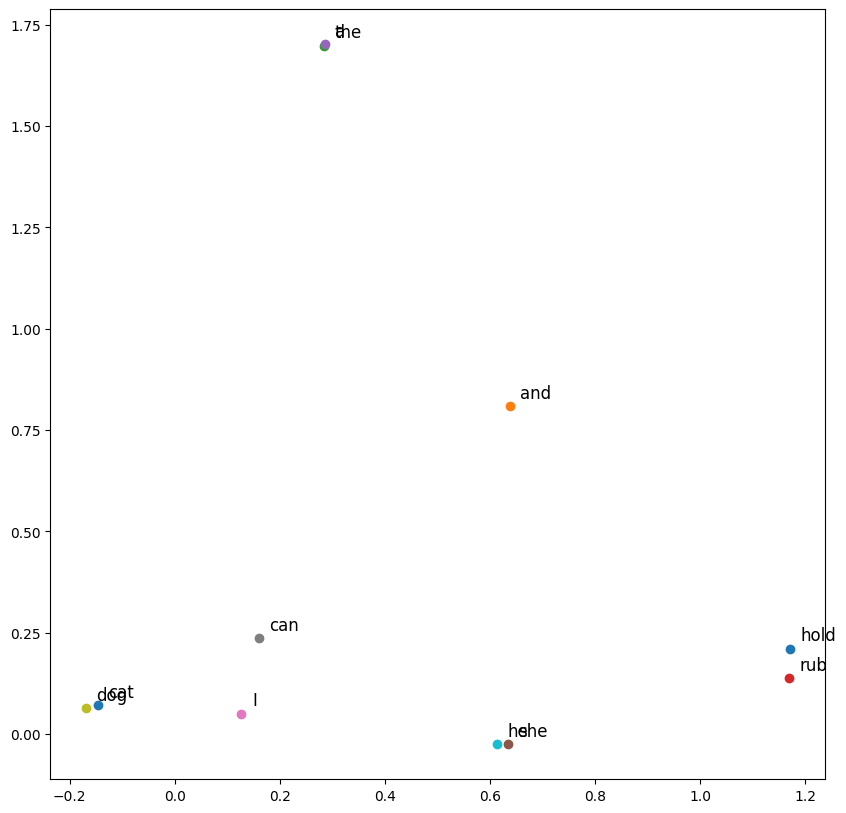

In [ ]:
# Visualize the embeddings
import matplotlib.pyplot as plt

def plot_embeddings(model, i2v):
    embeddings = model.embedding.data.numpy()
    plt.figure(figsize=(10, 10))
    for i, word in i2v.items():
        x, y = embeddings[i]
        plt.scatter(x, y)
        plt.text(x + 0.02, y + 0.02, word, fontsize=12)
    plt.show()

plot_embeddings(model, i2v)

Do the results make sense, and confirm your choices from part 1 of this Section?
Answer: Yes the similar context words do appear to closer in the 2-dimensional embedded space

What would happen when the window size is too large?
Answer: A larger window size means that more distant words are considered as context words. While nearby words are often strongly related to the target word, more distant words might not be as closely related, introducing noise into the training data. This can make the model less effective at capturing meaningful relationships between words.

At what value would window become too large for this corpus?
Answer: Anything window size larger than 7. This is because our sentences are 5-10 words and if we have a larger than 7 window we would be creating many context pairs across distant words.

# 4. Training A Single-Neuron Classifier to Determine if a Sentence is Objective or Subjective

The purpose of this exercise is to review the code for training a simple network (just a single neuron) to determine if a sentence is objective or subjective.

In [83]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.9 MB/s et

In [90]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import spacy
from torchtext.vocab import GloVe
import gradio as gr
import matplotlib.pyplot as plt

In [85]:
# Upload the file data.tsv in colab and Load the data
df = pd.read_csv('data.tsv', sep='\t', header=None, names=['sentence', 'label'])
df = df.loc[1:]

Take a quick look at the file data.tsv to see which sentences were labelled subjective (1) and which objective (0). (The 1’s are in the first half of the file)

Read through each of the code blocks, getting a rough sense of what is going on by reading the comments.
You see code functions that split the dataset, in the tab-separated file data.tsv into training, validation and test sets.
Perhaps look closest at the code block call “Classifier model” class where you can see the torch.nn.Linear class being used to instantiate a single neuron with embedding_size inputs and just 1 output.

In [86]:
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Load GloVe embeddings using torchtext
glove = GloVe(name='6B', dim=50)
embedding_size = 50  # Size of GloVe embeddings

# Function to convert a sentence to an embedding by averaging word embeddings
def sentence_to_embedding(sentence, glove):
    tokens = [token.text for token in nlp(sentence) if token.is_alpha]
    embeddings = [glove[token] for token in tokens if token in glove.stoi]
    if embeddings:
        return torch.mean(torch.stack(embeddings), dim=0)
    else:
        return torch.zeros(embedding_size)

# Convert all sentences to embeddings at once
def convert_sentences_to_embeddings(sentences, glove):
    embeddings = [sentence_to_embedding(sentence, glove) for sentence in sentences]
    return torch.stack(embeddings)

# Splitting the data into train, validation, and test sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['sentence'], df['label'], test_size=0.2, random_state=42)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_sentences, train_labels, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

train_embeddings = convert_sentences_to_embeddings(train_sentences, glove)
val_embeddings = convert_sentences_to_embeddings(val_sentences, glove)
test_embeddings = convert_sentences_to_embeddings(test_sentences, glove)

In [87]:
# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return embedding, torch.tensor(float(label), dtype=torch.float32)

# Convert to dataset
train_dataset = TextDataset(train_embeddings, train_labels.tolist())
val_dataset = TextDataset(val_embeddings, val_labels.tolist())
test_dataset = TextDataset(test_embeddings, test_labels.tolist())

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [88]:
# Define the classifier model
class ClassifierModel(nn.Module):
    def __init__(self, input_size):
        super(ClassifierModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(x)


Epoch 1, Training Loss: 0.6847, Validation Loss: 0.6677, Validation Accuracy: 0.7290
Epoch 2, Training Loss: 0.6507, Validation Loss: 0.6342, Validation Accuracy: 0.8180
Epoch 3, Training Loss: 0.6202, Validation Loss: 0.6043, Validation Accuracy: 0.8460
Epoch 4, Training Loss: 0.5931, Validation Loss: 0.5776, Validation Accuracy: 0.8640
Epoch 5, Training Loss: 0.5692, Validation Loss: 0.5539, Validation Accuracy: 0.8670
Epoch 6, Training Loss: 0.5476, Validation Loss: 0.5325, Validation Accuracy: 0.8720
Epoch 7, Training Loss: 0.5283, Validation Loss: 0.5134, Validation Accuracy: 0.8760
Epoch 8, Training Loss: 0.5111, Validation Loss: 0.4963, Validation Accuracy: 0.8790
Epoch 9, Training Loss: 0.4957, Validation Loss: 0.4807, Validation Accuracy: 0.8810
Epoch 10, Training Loss: 0.4815, Validation Loss: 0.4666, Validation Accuracy: 0.8830
Epoch 11, Training Loss: 0.4690, Validation Loss: 0.4538, Validation Accuracy: 0.8850
Epoch 12, Training Loss: 0.4575, Validation Loss: 0.4421, Valid

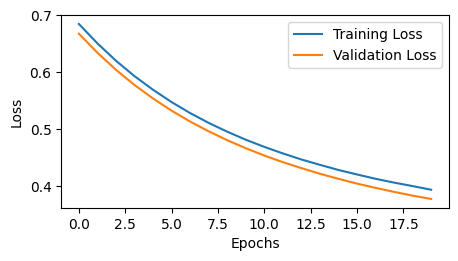

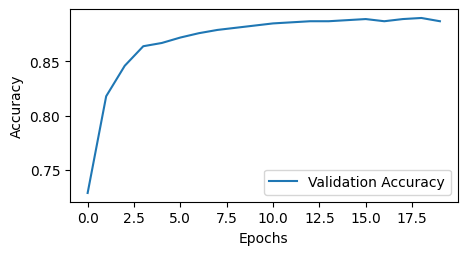



Test Loss: 0.3898, Accuracy: 0.8745


In [91]:
#Initialize the model
model = ClassifierModel(embedding_size)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        batch_train_losses = []
        for embeddings, labels in train_loader:
            labels = labels.view(-1, 1)

            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        model.eval()
        batch_val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():
            for embeddings, labels in val_loader:
                labels = labels.view(-1, 1)

                outputs = model(embeddings)
                loss = criterion(outputs, labels)

                batch_val_losses.append(loss.item())

                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss = np.mean(batch_train_losses)
        val_loss = np.mean(batch_val_losses)
        val_accuracy = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, val_accuracies

num_epochs = 20
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plotting training and validation losses
plt.figure(figsize=(5, 2.5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(5, 2.5))
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Define the function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            labels = labels.view(-1, 1)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Loss: {np.mean(test_losses):.4f}, Accuracy: {accuracy:.4f}')

print("\n")
evaluate_model(model, test_loader)

Run the remaining code, which installs the gradio package and sets up an easy-to-use inter- face with the trained model, that you can type in any sentence and have the model decide if it is subjective or objective. To use the interface, just type in the sentence and click the classify button. You may find that it is better at classifying longer sentences, as that is the nature of the dataset it was trained on.

In [92]:
# Define the Gradio interface
def classify_sentence(sentence):
    embedding = sentence_to_embedding(sentence, glove)
    embedding = embedding.unsqueeze(0)
    output = model(embedding)
    label = 'Subjective' if output > 0.5 else 'Objective'
    return label

gr.Interface(fn=classify_sentence, inputs="text", outputs="text").launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://87e008d7762471abdc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
